# Machine Learning (Final Project)

# Import some required libraries

In [44]:
!pip install -U imbalanced-learn


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import IsolationForest

# Load data and data preprocess

## Load data

In [46]:
# Load data
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Malware_subset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# sns.boxplot(data=df)
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed
# plt.title("Boxplot for All Features")
# plt.show()

# Data preprocessing

In [48]:
# Label Encoder
encoder = LabelEncoder()
encoded = encoder.fit_transform(df['Label'])
df['Label'] = encoder.fit_transform(df['Label'])


In [49]:
def remove_outlier_features(df, threshold=0.1):
    """Remove columns with too many outliers based on IQR method."""
    num_rows = df.shape[0]  # Total number of rows
    outlier_columns = []  # Store columns to remove

    for col in df.select_dtypes(include=["number"]).columns:  # Process only numerical columns
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

        # Check if outliers exceed threshold percentage
        if (outliers / num_rows) > threshold:
            outlier_columns.append(col)

    # Drop columns with too many outliers
    df_cleaned = df.drop(columns=outlier_columns)
    return df_cleaned, outlier_columns

# Remove columns with more than 10% outliers
df, removed_columns = remove_outlier_features(df, threshold=0.8)
removed_columns

[]

In [50]:
# Replace np.inf and -np.inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop np.nan numbers
print(f"NAN number: {df.isnull().sum()}")

# Using IQR to filter outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Before: {df.index}")
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
print(f"After: {df.index}")

# Drop duplicated data
df = df.drop_duplicates()
print(f"Duplicated data: {df.duplicated().sum()}")

# Handle missing data
print(f"Missing data's number: {df.isna().sum()}")

# Drop features with the full 0 or -1
df = df.loc[:, ~((df == 0) | (df == -1)).all(axis=0)]

# Remove anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df)

# Keep only normal data points
df = df[outliers == 1]

# Split the features and labels
X = df.drop('Label', axis=1)
y = df["Label"]

# Standardization
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# # Choose important features
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
selected_features = X.columns[np.abs(lasso.coef_) > 0]
X = X[selected_features]

# # Remove unimportant features
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(X)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Since it's the imbalanced data, i use SMOTE to oversampling datasets
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

NAN number:  Source Port          0
 Destination Port     0
 Protocol             0
 Flow Duration        0
 Total Fwd Packets    0
                     ..
Idle Mean             0
 Idle Std             0
 Idle Max             0
 Idle Min             0
Label                 0
Length: 81, dtype: int64
Before: RangeIndex(start=0, stop=834695, step=1)
After: Index([    73,    218,    271,    334,    697,    757,    793,    949,   1017,
         1074,
       ...
       833418, 833420, 833421, 833491, 834029, 834197, 834285, 834331, 834630,
       834691],
      dtype='int64', length=15075)
Duplicated data: 0
Missing data's number:  Source Port          0
 Destination Port     0
 Protocol             0
 Flow Duration        0
 Total Fwd Packets    0
                     ..
Idle Mean             0
 Idle Std             0
 Idle Max             0
 Idle Min             0
Label                 0
Length: 81, dtype: int64


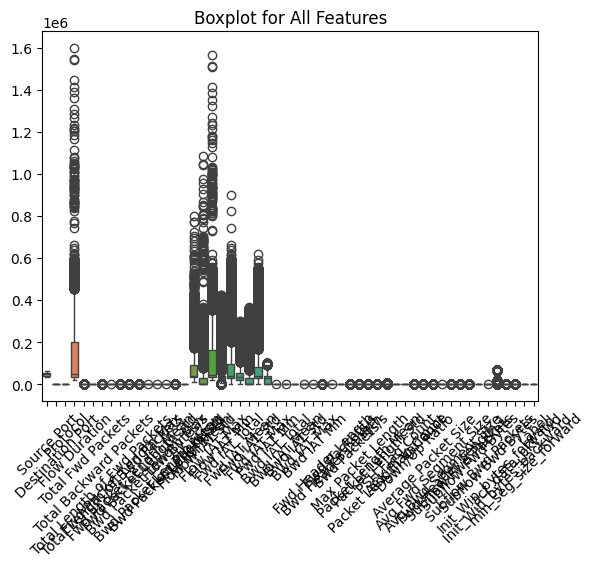

In [51]:
sns.boxplot(data=df)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("Boxplot for All Features")
plt.show()

In [52]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Data/cooked.csv', index=False)
# df

# Choose the model

In [53]:
df

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,...,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Label
73,50866,80,6,356225,3,0,0.0,0.0,0.0,0.0,...,60,3,0,0,0,1369,-1,0,20,2
218,60057,80,6,85043,3,0,0.0,0.0,0.0,0.0,...,60,3,0,0,0,1386,-1,0,20,2
271,57416,80,6,40365,3,0,0.0,0.0,0.0,0.0,...,60,3,0,0,0,1369,-1,0,20,2
334,60189,80,6,424181,1,1,0.0,0.0,0.0,0.0,...,20,1,0,1,0,1568,229,0,20,2
697,40316,80,6,274110,3,0,0.0,0.0,0.0,0.0,...,60,3,0,0,0,1369,-1,0,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834197,59340,443,6,270084,1,1,0.0,0.0,0.0,0.0,...,32,1,0,1,0,2190,0,0,32,10
834285,57677,443,6,21225,1,1,0.0,0.0,0.0,0.0,...,32,1,0,1,0,2681,74,0,32,10
834331,51906,443,6,43453,3,0,0.0,0.0,0.0,0.0,...,96,3,0,0,0,1502,-1,0,32,10
834630,48908,443,6,35790,1,1,0.0,0.0,0.0,0.0,...,32,1,0,1,0,1635,361,0,32,10


In [54]:
# # Use Random Forest Model
def RandomForestModel(n_estimators=100):
  rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
  rf.fit(X_train, y_train)
  # Make predictions
  return rf.predict(X_test)

In [55]:
from imblearn.ensemble import BalancedBaggingClassifier

def BalancedBaggingModel():
    #Create an instance
    classifier = BalancedBaggingClassifier(estimator=RandomForestClassifier(),
                                    sampling_strategy='not majority',
                                    replacement=False,
                                    random_state=42)
    classifier.fit(X_train, y_train)
    return classifier.predict(X_test)

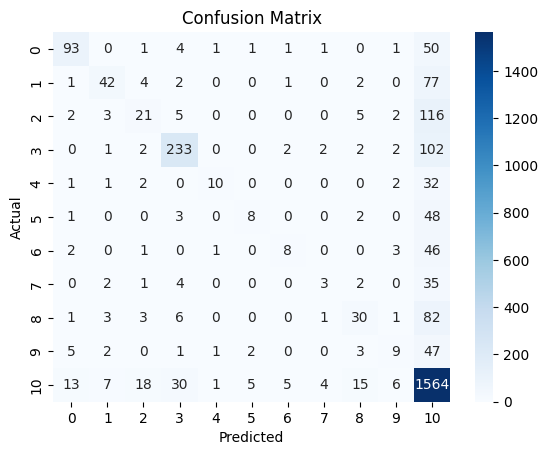

0.6616719742943137


In [56]:
y_pred = RandomForestModel(200)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)